## 네이버 검색 API 활용

In [ ]:
# API 접근을 위한 클라이언트 정보 설정
client_id = "U5rbjkxsN4LkZOx01N4r" 
client_secret = "BWX8wnIebt"

In [74]:
import os
os.chdir(r"C:\Users\lizzy\스파르타_파이썬\웹크롤링")
print(os.getcwd())  # 잘 바뀌었는지 확인

C:\Users\lizzy\스파르타_파이썬\웹크롤링


✅ API 요청 성공!
📁 JSON 데이터가 저장되었습니다: ./naver_trend_data\naver_trend_result.json


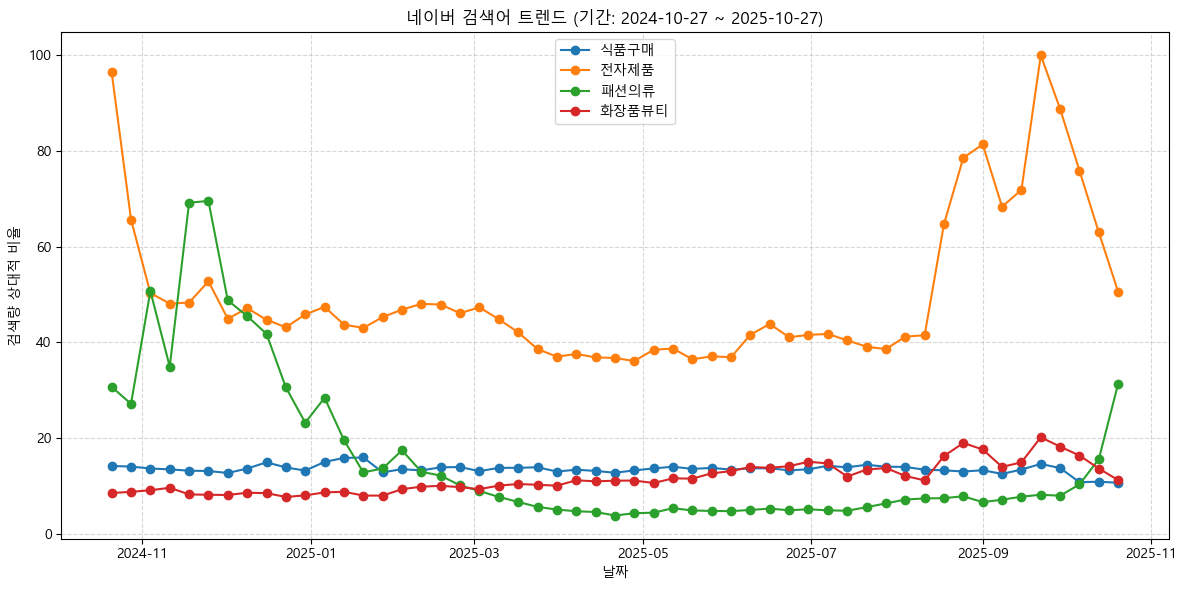

In [77]:
import os
os.chdir(r"C:\Users\lizzy\스파르타_파이썬\웹크롤링")

# 네이버 트렌드 API를 이용한 검색어 트렌드 데이터 수집 
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# API 인증 정보 설정
client_id = "U5rbjkxsN4LkZOx01N4r"
client_secret = "BWX8wnIebt"

# 저장 폴더 생성
output_dir = "./naver_trend_data"
os.makedirs(output_dir, exist_ok=True)

# 현재 날짜 기준으로 1년 전까지의 기간 설정
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=365)).strftime("%Y-%m-%d")

# 분석할 키워드 그룹 설정
keyword_groups = [
    {"groupName": "패션의류", "keywords": ["남성의류", "여성의류", "패딩", "아우터"]},
    {"groupName": "전자제품", "keywords": ["스마트폰", "노트북", "이어폰", "스마트워치"]},
    {"groupName": "화장품뷰티", "keywords": ["스킨케어", "립스틱", "선크림", "파운데이션"]},
    {"groupName": "식품구매", "keywords": ["배달음식", "밀키트", "과일", "신선식품"]}
]

# API 요청 헤더 설정
headers = {
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret,
    "Content-Type": "application/json"
}

# API 엔드포인트
api_url = "https://openapi.naver.com/v1/datalab/search"

# 요청 본문 데이터
request_body = {
    "startDate": start_date,
    "endDate": end_date,
    "timeUnit": "week",  # 주간 단위로 데이터 요청
    "keywordGroups": keyword_groups
}

# API 요청 실행
response = requests.post(api_url, headers=headers, data=json.dumps(request_body))

if response.status_code == 200:
    print("✅ API 요청 성공!")
    result_data = response.json()

    # JSON 파일로 저장
    json_path = os.path.join(output_dir, "naver_trend_result.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(result_data, f, ensure_ascii=False, indent=4)
    print(f"📁 JSON 데이터가 저장되었습니다: {json_path}")

    # 결과 데이터프레임 변환
    all_df = pd.DataFrame()
    for group in result_data['results']:
        df = pd.DataFrame(group['data'])
        df['groupName'] = group['title']
        all_df = pd.concat([all_df, df], ignore_index=True)

    # 날짜 변환
    all_df['period'] = pd.to_datetime(all_df['period'])

    # 피벗 테이블로 변환
    trend_df = all_df.pivot(index='period', columns='groupName', values='ratio')

    # 그래프 시각화
    plt.figure(figsize=(12, 6))
    for col in trend_df.columns:
        plt.plot(trend_df.index, trend_df[col], marker='o', label=col)

    plt.title(f"네이버 검색어 트렌드 (기간: {start_date} ~ {end_date})")
    plt.xlabel("날짜")
    plt.ylabel("검색량 상대적 비율")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # 그래프 저장
    plt.show()

else:
    print("❌ API 요청 실패:", response.status_code, response.text)


In [81]:
# 카카오 맵 API를 활용한 할리스 카페 위치 정보 수집
import requests
import pandas as pd
import time
import os
from datetime import datetime
import folium
from folium.plugins import MarkerCluster
import webbrowser

# ==============================
# 1️⃣ API 기본 설정
# ==============================
API_KEY = "73ec4cb4834fd5e7142646da19d1bae0"  # 🔸 카카오 개발자 REST API 키로 변경
headers = {"Authorization": f"KakaoAK {API_KEY}"}
api_url = "https://dapi.kakao.com/v2/local/search/address.json"

# ==============================
# 2️⃣ 지오코딩 함수
# ==============================
def geocode_address(address):
    """
    주소를 위도(lat), 경도(lng)로 변환하는 함수
    """
    params = {"query": address}
    try:
        response = requests.get(api_url, headers=headers, params=params, timeout=5)

        if response.status_code == 200:
            result = response.json()
            if result.get("documents"):
                location = result["documents"][0]
                lat = float(location["y"])
                lng = float(location["x"])
                return lat, lng
            else:
                print(f"❌ 주소를 찾을 수 없음: {address}")
                return None, None
        else:
            print(f"❌ API 요청 실패 ({response.status_code}): {response.text}")
            return None, None

    except Exception as e:
        print(f"⚠️ 오류 발생 ({address}): {e}")
        return None, None

# ==============================
# 3️⃣ CSV 파일 불러오기
# ==============================
input_path = "hollys_stores.csv"  # 🔸 같은 폴더에 있는 CSV 파일 이름

if not os.path.exists(input_path):
    raise FileNotFoundError(f"{input_path} 파일이 존재하지 않습니다!")

hollys_df = pd.read_csv(input_path)

# 매장명과 주소 컬럼명이 다를 수 있으니 확인
print("📄 원본 데이터 예시:")
print(hollys_df.head())

# ==============================
# 4️⃣ 주소 → 위도/경도 변환
# ==============================
latitudes = []
longitudes = []

for i, row in hollys_df.iterrows():
    address = row["address"]
    store_name = row["name"]
    print(f"[{i+1}/{len(hollys_df)}] {store_name} - {address}")

    lat, lng = geocode_address(address)
    latitudes.append(lat)
    longitudes.append(lng)

    # API 호출 간격 조정 (과도한 요청 방지)
    time.sleep(0.5)

hollys_df["latitude"] = latitudes
hollys_df["longitude"] = longitudes

# ==============================
# 5️⃣ 결과 저장
# ==============================
output_file = f"hollys_geocoded_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
hollys_df.to_csv(output_file, index=False, encoding="utf-8-sig")
print(f"\n✅ 지오코딩 완료! 결과 파일 저장: {output_file}")

# ==============================
# 6️⃣ 지도 시각화 (선택사항)
# ==============================
map_center = [hollys_df["latitude"].mean(), hollys_df["longitude"].mean()]
m = folium.Map(location=map_center, zoom_start=12)
marker_cluster = MarkerCluster().add_to(m)

for _, row in hollys_df.dropna(subset=["latitude", "longitude"]).iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=f"{row['name']}<br>{row['address']}",
        icon=folium.Icon(color="red", icon="coffee", prefix="fa")
    ).add_to(marker_cluster)

# HTML 파일로 저장
map_file = "hollys_map.html"
m.save(map_file)

# VSCode에서 바로 열기
webbrowser.open(f"file://{os.path.abspath(map_file)}")
print(f"🗺️ 지도 파일 저장 및 브라우저에서 열기 완료: {map_file}")


📄 원본 데이터 예시:
       region       name status                                 address  \
0      서울 동작구   신대방삼거리역점    영업중            서울특별시 동작구 상도로 60 (대방동) 1층~2층   
1      전북 익산시      익산부송점    영업중  전라북도 익산시 하나로10길 70-1 (부송동, 레스트빌딩 1층) .   
2  경남 창원시 진해구      진해속천점    영업중         경상남도 창원시 진해구 태평로 132 (속천동) 2~3층   
3     서울 영등포구  여의도포스트타워점    영업중        서울특별시 영등포구 여의나루로 60 포스트타워 여의도 1층   
4     서울 영등포구       대림역점    영업중            서울특별시 영등포구 도림로 140 대림빌딩 101호   

  service          phone  
0     NaN    02-823-2377  
1      주차   063-832-1717  
2  테라스 주차  070-7786-1019  
3      주차   02-2135-5321  
4     테라스    02-834-1000  
[1/20] 신대방삼거리역점 - 서울특별시 동작구 상도로 60 (대방동) 1층~2층
[2/20] 익산부송점 - 전라북도 익산시 하나로10길 70-1 (부송동, 레스트빌딩 1층) .
[3/20] 진해속천점 - 경상남도 창원시 진해구 태평로 132 (속천동) 2~3층
❌ 주소를 찾을 수 없음: 경상남도 창원시 진해구 태평로 132 (속천동) 2~3층
[4/20] 여의도포스트타워점 - 서울특별시 영등포구 여의나루로 60 포스트타워 여의도 1층
[5/20] 대림역점 - 서울특별시 영등포구 도림로 140 대림빌딩 101호
[6/20] 부산동래온천점 - 부산광역시 동래구 금강로 116 (온천동) 금강메디컬타워 1층
[7/20] 충정로역점 - 서울특별시 서대문구 경기대로 2